In [1]:
# General imports
import pandas
import datetime
import numpy
# ML imports
import hdbscan
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy import utils
%pylab inline

/usr/local/lib/python2.7/dist-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/usr/local/lib/python2.7/dist-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/usr/local/lib/python2.7/dist-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/usr/local/lib/python2.7/dist-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/usr/local/lib/python2.7/dist-packages/pandas/core/indexes/base.py:7: RuntimeWarning: numpy.dtype size changed, may indicate bi

/usr/local/lib/python2.7/dist-packages/sklearn/utils/graph.py:15: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path  # noqa
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/least_angle.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y, deprecated
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:29: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cd_fast
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/__init__.py:22: Runtime

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/scipy/signal/_max_len_seq.py:8: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._max_len_seq_inner import _max_len_seq_inner
/usr/local/lib/python2.7/dist-packages/scipy/signal/_upfirdn.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._upfirdn_apply import _output_len, _apply
/usr/local/lib/python2.7/dist-packages/scipy/ndimage/measurements.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _ni_label
/usr/local/lib/python2.7/dist-packages/scipy/signal/spectral.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._spectral import lombscargle


In [2]:
tecDF = pandas.read_feather("./mftec-20130117-2025.feather")
# Re-scale Mlon to -180 to 180 (from 0 to 360)
tecDF["adjstMlons"] = [ b - 360. if b > 180. else\
             b for b in tecDF["Mlon"] ]
tecDF.head()

/usr/local/lib/python2.7/dist-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


,date,Mlat,Mlon,med_tec,adjstMlons
0,2013-01-17 20:25:00,11.0,0.0,40.3,0.0
1,2013-01-17 20:25:00,11.0,2.0,45.8,2.0
2,2013-01-17 20:25:00,11.0,4.0,46.4,4.0
3,2013-01-17 20:25:00,11.0,6.0,46.1,6.0
4,2013-01-17 20:25:00,11.0,8.0,44.5,8.0


In [3]:
coords = "mag"
patchDate = pandas.to_datetime(tecDF["date"].values[0])

In [4]:
data = tecDF[ [ "Mlat", "adjstMlons", "med_tec" ] ].as_matrix()
stscaler = StandardScaler().fit(data)
data = stscaler.transform(data)
data[...,2] = data[...,2]*1.25
print data#stscaler.inverse_transform(data)

[[-1.83737204 -0.10054668  2.3629945 ]
 [-1.83737204 -0.07995769  2.87443289]
 [-1.83737204 -0.0593687   2.93022617]
 ...
 [ 1.78503099 -0.20349162 -0.98460223]
 [ 1.78503099 -0.18290264 -0.98460223]
 [ 1.78503099 -0.16231365 -0.98460223]]


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [5]:
# tecArr = numpy.histogram(data)
# print tecArr
# print numpy.min(data[...,2]), numpy.max(data[...,2]), numpy.median(data[...,2])

In [6]:
dbsc = DBSCAN(eps = 0.1, min_samples = 8,metric="euclidean").fit(data) #(0.12,8)
core_samples_mask = numpy.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
labels = dbsc.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
if n_clusters_ > 1:
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data, labels))
    # get a count of how many elements are in each bin
    uniqEl, counts = numpy.unique(labels,return_counts=True)
    print zip(uniqEl, counts)

Estimated number of clusters: 118
Silhouette Coefficient: -0.283
[(-1, 1434), (0, 79), (1, 31), (2, 15), (3, 2523), (4, 124), (5, 492), (6, 19), (7, 8), (8, 12), (9, 8), (10, 8), (11, 10), (12, 10), (13, 6), (14, 8), (15, 12), (16, 24), (17, 13), (18, 8), (19, 8), (20, 14), (21, 86), (22, 9), (23, 8), (24, 12), (25, 44), (26, 9), (27, 27), (28, 8), (29, 29), (30, 8), (31, 597), (32, 13), (33, 19), (34, 4), (35, 36), (36, 12), (37, 18), (38, 292), (39, 9), (40, 8), (41, 8), (42, 8), (43, 987), (44, 88), (45, 21), (46, 12), (47, 9), (48, 11), (49, 16), (50, 22), (51, 12), (52, 9), (53, 8), (54, 11), (55, 14), (56, 52), (57, 18), (58, 12), (59, 8), (60, 8), (61, 11), (62, 101), (63, 12), (64, 8), (65, 17), (66, 13), (67, 24), (68, 34), (69, 8), (70, 20), (71, 8), (72, 12), (73, 12), (74, 25), (75, 13), (76, 20), (77, 19), (78, 8), (79, 20), (80, 8), (81, 8), (82, 10), (83, 9), (84, 169), (85, 9), (86, 9), (87, 14), (88, 8), (89, 11), (90, 25), (91, 11), (92, 11), (93, 461), (94, 11), (95,

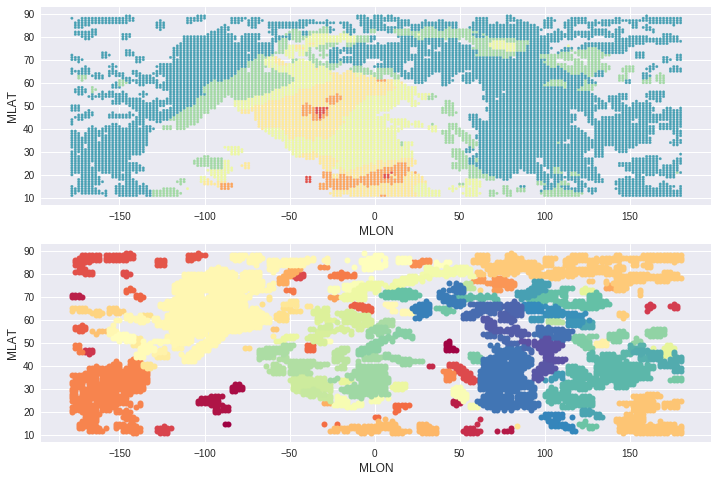

In [13]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,1,1)
ax2 = f.add_subplot(2,1,2)

# Plot the original data
dataOrig = stscaler.inverse_transform(data)
origDataPlt = ax1.scatter(dataOrig[:, 1], dataOrig[:, 0], c=dataOrig[:,2],
         marker='o', cmap=seaMap, s=6)
# cbar = plt.colorbar(origDataPlt, orientation='vertical', ax=ax1)
# cbar.set_label("TEC", fontsize=12)
ax1.set_xlabel("MLON", fontsize=12)
ax1.set_ylabel("MLAT", fontsize=12)

# Plot the clustered data
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)
    
    xy = dataOrig[class_member_mask & core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = dataOrig[class_member_mask & ~core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
ax2.set_xlabel("MLON", fontsize=12)
ax2.set_ylabel("MLAT", fontsize=12)

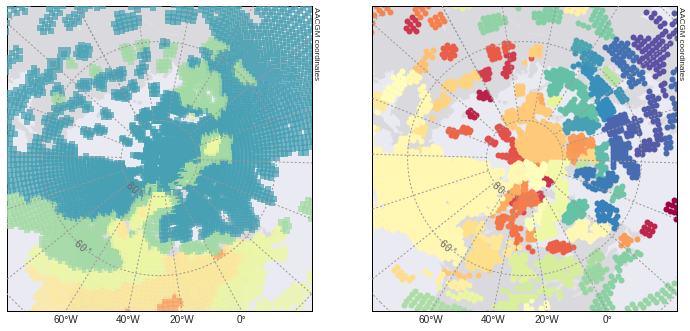

In [14]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)
# Original map
m1 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax1, datetime=patchDate)

xVec, yVec = m1(list(tecDF["Mlon"]),\
                list(tecDF["Mlat"]), coords=coords)
tecPlot = m1.scatter( xVec, yVec , c=tecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )
# cbar = plt.colorbar(tecPlot, orientation='vertical')
# cbar.set_label('TEC', size=15)
# Clustered map
m2 = utils.plotUtils.mapObj(boundinglat=50,\
            coords=coords, ax=ax2, datetime=patchDate)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)
    
    xy = dataOrig[class_member_mask & core_samples_mask]
    m2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, latlon=True)

    xy = dataOrig[class_member_mask & ~core_samples_mask]
    m2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, latlon=True)

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=7, gen_min_span_tree=True)
hdbsc = clusterer.fit(data)

In [10]:
# core_samples_mask = numpy.zeros_like(hdbsc.labels_, dtype=bool)
# core_samples_mask[hdbsc.core_sample_indices_] = True
labels = hdbsc.labels_
# hdbsc.
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
if n_clusters_ > 1:
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(data, labels))
    # get a count of how many elements are in each bin
    uniqEl, counts = numpy.unique(labels,return_counts=True)
    print zip(uniqEl, counts)

Estimated number of clusters: 148
Silhouette Coefficient: -0.146
[(-1, 2766), (0, 11), (1, 23), (2, 14), (3, 16), (4, 11), (5, 69), (6, 15), (7, 11), (8, 16), (9, 9), (10, 9), (11, 43), (12, 15), (13, 9), (14, 14), (15, 8), (16, 9), (17, 24), (18, 11), (19, 36), (20, 8), (21, 82), (22, 11), (23, 16), (24, 18), (25, 12), (26, 22), (27, 16), (28, 19), (29, 67), (30, 27), (31, 12), (32, 17), (33, 46), (34, 17), (35, 538), (36, 18), (37, 17), (38, 8), (39, 32), (40, 30), (41, 8), (42, 9), (43, 8), (44, 30), (45, 10), (46, 17), (47, 40), (48, 10), (49, 92), (50, 12), (51, 219), (52, 8), (53, 466), (54, 9), (55, 13), (56, 23), (57, 13), (58, 8), (59, 61), (60, 9), (61, 8), (62, 10), (63, 26), (64, 11), (65, 9), (66, 14), (67, 12), (68, 7), (69, 9), (70, 949), (71, 41), (72, 30), (73, 20), (74, 10), (75, 73), (76, 10), (77, 26), (78, 28), (79, 41), (80, 10), (81, 19), (82, 31), (83, 29), (84, 56), (85, 14), (86, 12), (87, 10), (88, 18), (89, 11), (90, 7), (91, 22), (92, 32), (93, 53), (94, 9)

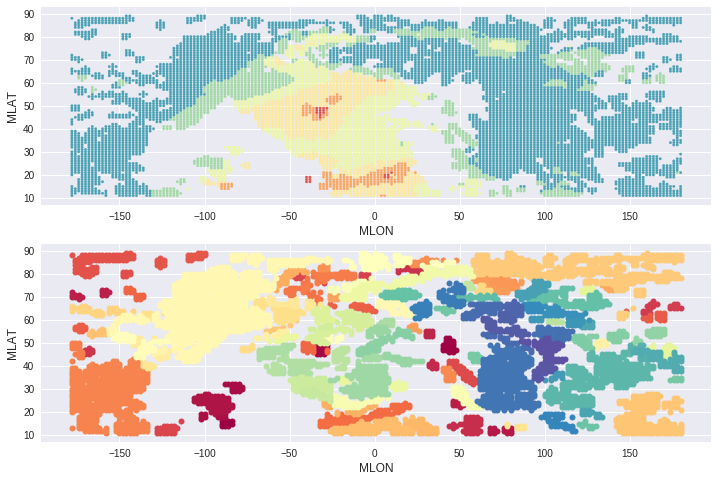

In [11]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,1,1)
ax2 = f.add_subplot(2,1,2)

# Plot the original data
dataOrig = stscaler.inverse_transform(data)
origDataPlt = ax1.scatter(dataOrig[:, 1], dataOrig[:, 0], c=dataOrig[:,2],
         marker='o', cmap=seaMap, s=6)
# cbar = plt.colorbar(origDataPlt, orientation='vertical', ax=ax1)
# cbar.set_label("TEC", fontsize=12)
ax1.set_xlabel("MLON", fontsize=12)
ax1.set_ylabel("MLAT", fontsize=12)

# Plot the clustered data
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue

    class_member_mask = (labels == k)
    
    xy = dataOrig[class_member_mask & core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

    xy = dataOrig[class_member_mask & ~core_samples_mask]
    ax2.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
ax2.set_xlabel("MLON", fontsize=12)
ax2.set_ylabel("MLAT", fontsize=12)

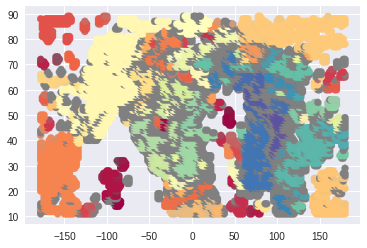

In [12]:
dataOrig = stscaler.inverse_transform(data)
palette = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(dataOrig.T[1], dataOrig.T[0], c=cluster_colors)